<a href="https://colab.research.google.com/github/daindq/project1/blob/main/Project_1_stdnt_id_20191724.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with U-Net

### 0. Set up

In [2]:
#Import packages
import tensorflow as tf
import numpy as np
import os
from zipfile import ZipFile
from google.colab import drive
from skimage.io import imread, imshow
from skimage.transform import resize
import random
from re import I
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

from keras import backend as K
import cv2 
from keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras.layers import*
from tensorflow.keras.models import Model
from tensorflow.keras.applications import*
from tensorflow.keras.utils import plot_model

Mount drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Authenticate and create the PyDrive client.

In [3]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

### 1. Load and preprocess data

> Const



In [4]:
seed = 1234
np.random.seed = seed
TRAIN_PATH = "/content/ISIC-2017_Training_Data"
TRAIN_MASK_PATH = "/content/ISIC-2017_Training_Part1_GroundTruth"
TEST_PATH = "/content/ISIC-2017_Test_v2_Data"
TEST_MASK_PATH = "/content/ISIC-2017_Test_v2_Part1_GroundTruth"
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CHANNEL = 3
#Data uploaded to GDrive and mounted to colab.
file_location = ["/content/drive/MyDrive/Project 1/ISIC-2017_Training_Data.zip",
                 "/content/drive/MyDrive/Project 1/ISIC-2017_Training_Part1_GroundTruth.zip", 
                 "/content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Data.zip", 
                 "/content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Part1_GroundTruth.zip"]

#_________________________________________________________________________________________________________________________________________________________________________



> (Download and) Extract files to Colab Virtual machine.



In [5]:
for location in file_location:
  print(f'Extracting {location}')
  with ZipFile(f'{location}', 'r') as zipObj:
    zipObj.extractall(f'/content')
  print(f'{location} extracted!')
#_______________________________________________________________________________________________________________________________________________________________________
# for name, id in file_ids.items():
#   dfile = drive.CreateFile({'id':id})
#   dfile.GetContentFile(f'{name}.zip')
#   with ZipFile(f'{name}.zip', 'r') as zipObj:
#    zipObj.extractall(f'/content/{name}')


Extracting /content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Data.zip
/content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Data.zip extracted!
Extracting /content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Part1_GroundTruth.zip
/content/drive/MyDrive/Project 1/ISIC-2017_Test_v2_Part1_GroundTruth.zip extracted!



> Read data


In [6]:
#Get images id
train_img_id = next(os.walk(TRAIN_MASK_PATH))[2]
test_img_id = next(os.walk(TEST_MASK_PATH))[2]

train_img_id = [item.split('_', 2)[1] for item in train_img_id]
test_img_id = [item.split('_', 2)[1] for item in test_img_id]

print(len(train_img_id))
#Train and Test array init
X_train = np.zeros((len(train_img_id), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)
Y_train = np.zeros((len(train_img_id), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
X_test = np.zeros((len(test_img_id), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)
Y_test = np.zeros((len(test_img_id), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#Load Train data
print("Loading train data!")
for n, id in enumerate(train_img_id):
    print(f'Loading data {n} over {len(train_img_id)}')
    path = f'{TRAIN_PATH}/ISIC_{id}.jpg'
    img = imread(path)[:,:,:NUM_CHANNEL]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    path = f'{TRAIN_MASK_PATH}/ISIC_{id}_segmentation.png'
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask = imread(path)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    Y_train[n] = mask 
Y_train = np.asarray(Y_train,dtype = np.float) 
X_train  = np.asarray(X_train,dtype= np.float)
#Load Test data
for n, id in enumerate(test_img_id):
    print(f'Loading data {n}/{len(test_img_id)}')
    path = f'{TEST_PATH}/ISIC_{id}.jpg'
    img = imread(path)[:,:,:NUM_CHANNEL]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    path = f'{TEST_MASK_PATH}/ISIC_{id}_segmentation.png'
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask = imread(path)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    Y_test[n] = mask 
Y_test = np.asarray(Y_test,dtype = np.float) 
X_test  = np.asarray(X_test,dtype= np.float)


2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]


Loading train data!
Loading data 0 over 2000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading data 1 over 2000
Loading data 2 over 2000
Loading data 3 over 2000
Loading data 4 over 2000
Loading data 5 over 2000
Loading data 6 over 2000
Loading data 7 over 2000
Loading data 8 over 2000
Loading data 9 over 2000
Loading data 10 over 2000
Loading data 11 over 2000
Loading data 12 over 2000
Loading data 13 over 2000
Loading data 14 over 2000
Loading data 15 over 2000
Loading data 16 over 2000
Loading data 17 over 2000
Loading data 18 over 2000
Loading data 19 over 2000
Loading data 20 over 2000
Loading data 21 over 2000
Loading data 22 over 2000
Loading data 23 over 2000
Loading data 24 over 2000
Loading data 25 over 2000
Loading data 26 over 2000
Loading data 27 over 2000
Loading data 28 over 2000
Loading data 29 over 2000
Loading data 30 over 2000
Loading data 31 over 2000
Loading data 32 over 2000
Loading data 33 over 2000
Loading data 34 over 2000
Loading data 35 over 2000
Loading data 36 over 2000
Loading data 37 over 2000
Loading data 38 over 2000
Loading data 39 over 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading data 0/600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading data 1/600
Loading data 2/600
Loading data 3/600
Loading data 4/600
Loading data 5/600
Loading data 6/600
Loading data 7/600
Loading data 8/600
Loading data 9/600
Loading data 10/600
Loading data 11/600
Loading data 12/600
Loading data 13/600
Loading data 14/600
Loading data 15/600
Loading data 16/600
Loading data 17/600
Loading data 18/600
Loading data 19/600
Loading data 20/600
Loading data 21/600
Loading data 22/600
Loading data 23/600
Loading data 24/600
Loading data 25/600
Loading data 26/600
Loading data 27/600
Loading data 28/600
Loading data 29/600
Loading data 30/600
Loading data 31/600
Loading data 32/600
Loading data 33/600
Loading data 34/600
Loading data 35/600
Loading data 36/600
Loading data 37/600
Loading data 38/600
Loading data 39/600
Loading data 40/600
Loading data 41/600
Loading data 42/600
Loading data 43/600
Loading data 44/600
Loading data 45/600
Loading data 46/600
Loading data 47/600
Loading data 48/600
Loading data 49/600
Loading data 50/600
Loading d

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [5]:
print("X_train dimension : {}".format(X_train.shape))
print("Y_train dimension : {}".format(Y_train.shape))
print("X_test dimension  : {}".format(X_test.shape))
print("Y_test dimension  : {}".format(Y_test.shape))

NameError: ignored

In [10]:
# Sử dụng pickle để lưu lại đối tượng data để sử dụng sau này
def save_file(obj, file_path):
  with open(file_path, 'wb') as f:
    pickle.dump(obj, f)
pickle_path = "/content/drive/MyDrive/data18_81"

os.makedirs(pickle_path) 

# save_file(train_img_id,os.path.join(pickle_path,"./train_img_id.pkl"))
# save_file(test_img_id,os.path.join(pickle_path,"./test_img_id.pkl"))
save_file(X_train,os.path.join(pickle_path,"./Xtrain.pkl"))
save_file(Y_train,os.path.join(pickle_path,"./Ytrain.pkl"))
# save_file(X_test,os.path.join(pickle_path,"./Xtest.pkl"))
# save_file(Y_test,os.path.join(pickle_path,"./Ytest.pkl"))

In [3]:
N = random.randint(0,1999)
img = X_train[N]
mask = Y_train[N]

fig, arr = plt.subplots(1, 2, figsize=(25, 10))
arr[0].imshow(img/255.0)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
fig.suptitle(f'Data visualization of img no.{N} - ID {train_img_id[N]}', fontsize = 24)

NameError: ignored

### 2. Load Data (for 2nd time)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# id_drive = 5
# pkl_link = "https://drive.google.com/file/d/1MfY1PD70Lyta-yUu9kYrNkr6KldOjyzp/view?usp=sharing"
# pkl = pkl_link.split("/")[id_drive]


In [ ]:
# for name, id in file_ids.items():
#   dfile = drive.CreateFile({'id':id})
#   dfile.GetContentFile(f'{name}.zip')
#   with ZipFile(f'{name}.zip', 'r') as zipObj:
#    zipObj.extractall(f'/content/{name}')

In [7]:
def load_file(file_path):
  with open(file_path, 'rb') as f:
    obj = pickle.load(f)
  return obj

pickle_path = "/content/drive/MyDrive/data18_8"

# train_img_id = load_file(os.path.join(pickle_path,"./train_img_id.pkl"))
# test_img_id = load_file(os.path.join(pickle_path,"./test_img_id.pkl"))
# X_train = load_file(os.path.join(pickle_path,"./Xtrain.pkl"))
# Y_train = load_file(os.path.join(pickle_path,"./Ytrain.pkl"))
# X_test = load_file(os.path.join(pickle_path,"./Xtest.pkl"))
# Y_test = load_file(os.path.join(pickle_path,"./Ytest.pkl"))

In [9]:
print("X_train dimension : {}".format(X_train.shape))
print("Y_train dimension : {}".format(Y_train.shape))
# print("X_test dimension : {}".format(X_test.shape))
# print("Y_test dimension : {}".format(Y_test.shape))

X_train dimension : (2000, 256, 256, 3)
Y_train dimension : (2000, 256, 256, 1)


IndexError: ignored

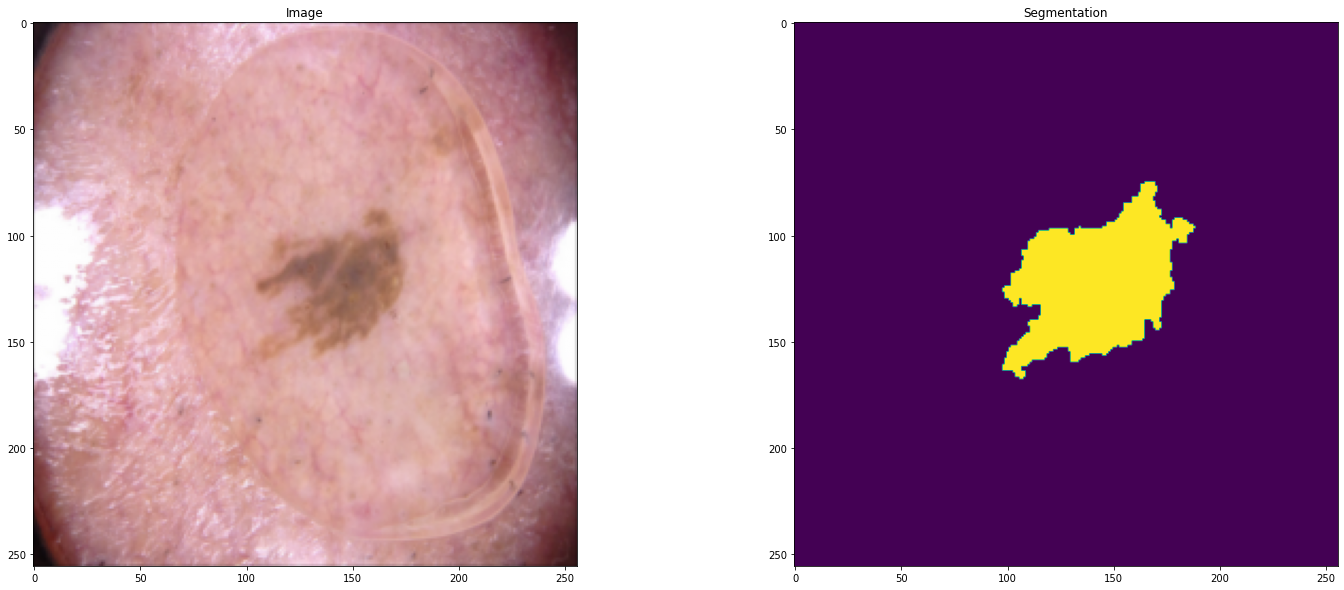

In [10]:
N = random.randint(0,1999)
img = X_train[N]
mask = Y_train[N]

fig, arr = plt.subplots(1, 2, figsize=(25, 10))
arr[0].imshow(img/255.0)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')
fig.suptitle(f'Data visualization of img no.{N} - ID {train_img_id[N]}', fontsize = 24)

### 3. U-Net model

> Hyperparameter



In [16]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_CHANNEL = 3
BATCH_SIZE = 16
EPOCH = 300
learning_rate = 1e-4
Validation_split = 0.1
save_path = "/content/drive/MyDrive/Unet.h5"
seed = 1234
np.random.seed = seed

> Define model



In [17]:
# define model
def Unet():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL))
  s = tf.keras.layers.Lambda(lambda x: x / 255.0)(inputs)

  #Contraction path
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = Dropout(0.1)(c1)
  c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = MaxPooling2D((2, 2))(c1)

  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = Dropout(0.1)(c2)
  c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = MaxPooling2D((2, 2))(c2)
 
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = MaxPooling2D((2, 2))(c3)
 
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = Dropout(0.3)(c5)
  c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

  #Expansive path 
  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = Dropout(0.1)(c8)
  c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = Dropout(0.1)(c9)
  c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
  model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
  optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
  model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=["accuracy",dice_coef,jaccard_coef,IoU,])
  return model

> Metric



In [18]:
# custom metric
def IoU(y_true, y_pred, smooth=0):
  """
  y_tru: bs,h,w,c
  """
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true + y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)
    
def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, 0)
    #return 1.0 - dice_coef(y_true, y_pred)
    
def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true + y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

> Callback



In [19]:
# plot losses
class PlotLosses(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.i = 0
    self.x = []
    # losses
    self.losses = []
    self.val_losses = []

    # accuracy
    self.accuracy = []
    self.val_accuracy = []

    # dice_coef
    self.dice_coef = []
    self.val_dice_coef = []

    # IoU
    self.IoU = []
    self.val_IoU = []
        
    self.fig = plt.figure()
    self.logs = []

  def on_epoch_end(self, epoch, logs={}):
        
    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))

    self.accuracy.append(logs.get('accuracy'))
    self.val_accuracy.append(logs.get('val_accuracy'))

    self.dice_coef.append(logs.get('dice_coef'))
    self.val_dice_coef.append(logs.get('val_dice_coef'))

    self.IoU.append(logs.get('IoU'))
    self.val_IoU.append(logs.get('val_IoU'))
    self.i += 1
        
    clear_output(wait=True)

    fg , ax = plt.subplots(2,2,figsize = (16,8))
    fg.suptitle("Results training after {} epochs".format(self.i))

    ax[0,0].plot(self.x,self.losses,label = 'loss')
    ax[0,0].plot(self.x,self.val_losses,label = 'val_losses')
    ax[0,0].set_xlabel("min loss {}--min val_loss {}".format(np.round(min(self.losses),2),np.round(min(self.val_losses),2)))
    # ax[0,0].set_xlabel("losses")
    ax[0,0].legend()
        
    ax[0,1].plot(self.x,self.accuracy,label = 'accuracy')
    ax[0,1].plot(self.x,self.val_accuracy,label = 'val_accuracy')
    ax[0,1].set_xlabel("max accuracy {}--max val_recall {}".format(np.round(max(self.accuracy),2),np.round(max(self.val_accuracy),2)))
    # ax[0,1].set_xlabel("accuracy")
    ax[0,1].legend()

    ax[1,0].plot(self.x,self.dice_coef,label = 'dice_coef')
    ax[1,0].plot(self.x,self.val_dice_coef,label = 'val_dice_coef')
    ax[1,0].set_xlabel("max dice_coef {}--max val_dice_coef {}".format(np.round(max(self.dice_coef),2),np.round(max(self.val_dice_coef),2)))
    # ax[1,0].set_xlabel("dice_coef")
    ax[1,0].legend()

    ax[1,1].plot(self.x,self.IoU,label = 'IoU')
    ax[1,1].plot(self.x,self.val_IoU,label = 'val_IoU')
    ax[1,1].set_xlabel("max IoU {}--max val_IoU {}".format(np.round(max(self.IoU),2),np.round(max(self.val_IoU),2)))
    # ax[1,1].set_xlabel("IoU")
    ax[1,1].legend()

    plt.show()
        
plot_losses = PlotLosses()

In [20]:
# callbacks
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=50, monitor="accuracy"),
        tf.keras.callbacks.ModelCheckpoint(save_path, verbose=2, save_best_only=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=20, min_lr=0.00001),
        plot_losses
            ]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


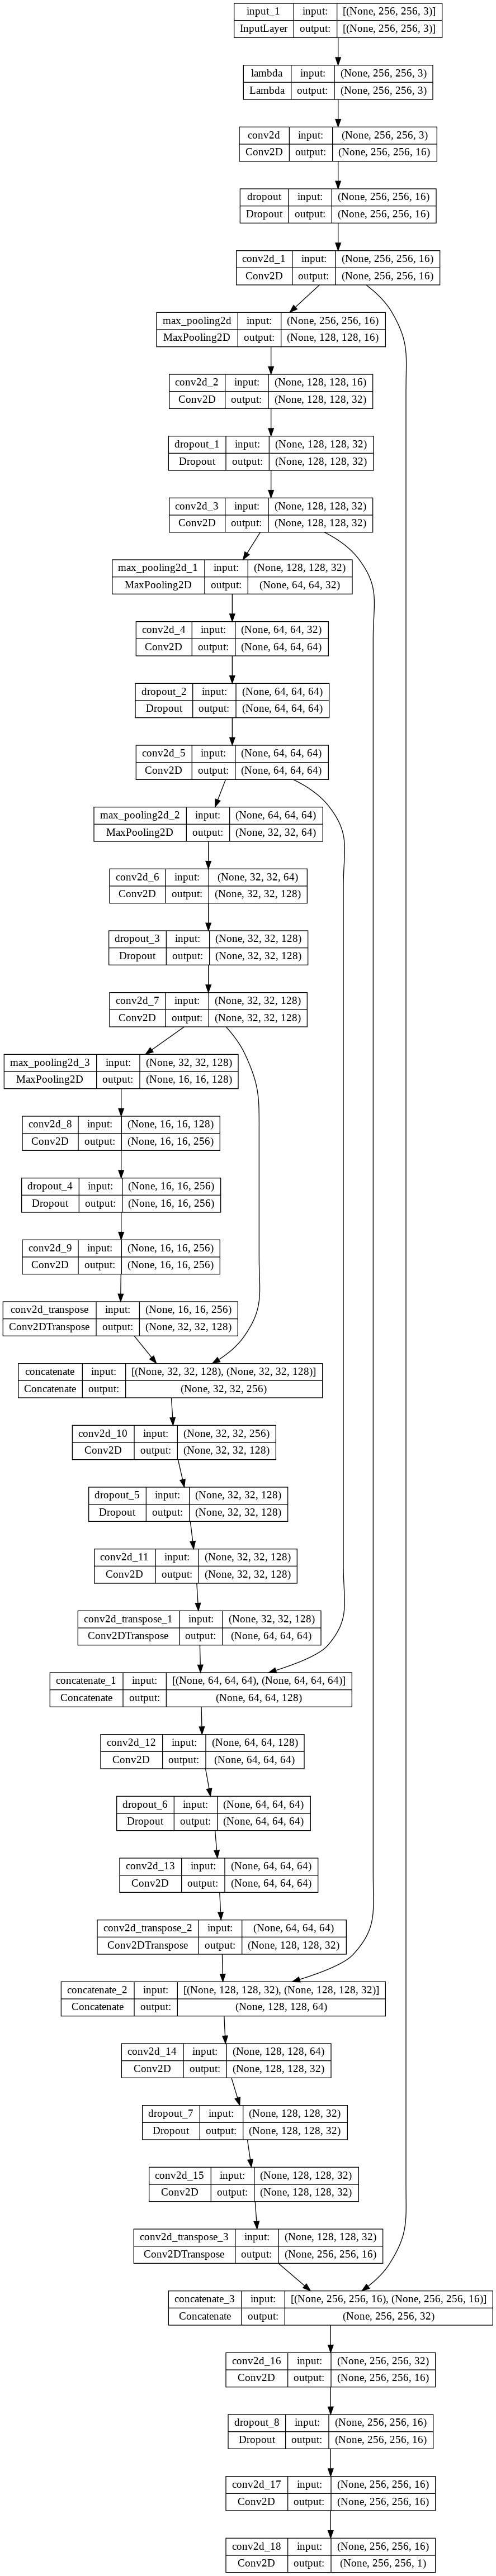

In [21]:
#compile
model = Unet()
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 4. Train model

In [18]:
# Check libcudnn8 version
!apt-cache policy libcudnn8

# Install latest version
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

# Export env variables
!export PATH=/usr/local/cuda-11.4/bin${PATH:+:${PATH}}
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/lib64:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=/usr/local/cuda-11.4/include:$LD_LIBRARY_PATH
!export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/usr/local/cuda/extras/CUPTI/lib64

# Install tensorflow
!pip install tflite-model-maker==0.4.0
!pip uninstall -y tensorflow && pip install -q tensorflow==2.9.1
!pip install pycocotools==2.0.4
!pip install opencv-python-headless==4.6.0.66


libcudnn8:
  Installed: 8.0.5.39-1+cuda11.1
  Candidate: 8.5.0.96-1+cuda11.7
  Version table:
     8.5.0.96-1+cuda11.7 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.5.0.96-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.1.50-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda11.6 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.4.0.27-1+cuda10.2 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda11.5 600
        600 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
     8.3.3.40-1+cuda10.2

Found existing installation: tensorflow 2.9.1
Uninstalling tensorflow-2.9.1:
  Successfully uninstalled tensorflow-2.9.1
     |████████████████████████████████| 511.7 MB 6.3 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


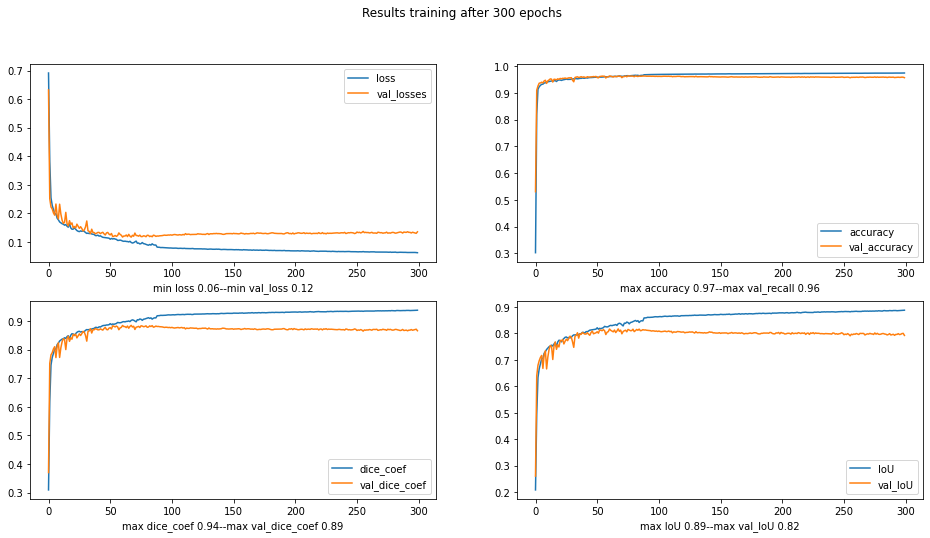

113/113 [==============================] - 19s 166ms/step - loss: 0.0620 - accuracy: 0.9738 - dice_coef: 0.9380 - jaccard_coef: 0.8881 - IoU: 0.8881 - val_loss: 0.1351 - val_accuracy: 0.9564 - val_dice_coef: 0.8662 - val_jaccard_coef: 0.7927 - val_IoU: 0.7927 - lr: 1.0000e-05


In [22]:
# train
History = model.fit(X_train, Y_train, validation_split=Validation_split, batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=callbacks)

In [ ]:
#Get images id
# train_img_id = next(os.walk(TRAIN_MASK_PATH))[2]
# test_img_id = next(os.walk(TEST_MASK_PATH))[2]

# train_img_id = [item.split('_', 2)[1] for item in train_img_id]
# test_img_id = [item.split('_', 2)[1] for item in test_img_id]

print(len(train_img_id))
#Train and Test array init
X_test = np.zeros((len(test_img_id), IMG_HEIGHT, IMG_WIDTH, NUM_CHANNEL), dtype=np.uint8)
Y_test = np.zeros((len(test_img_id), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
#Load Test data
for n, id in enumerate(test_img_id):
    print(f'Loading data {n}/{len(test_img_id)}')
    path = f'{TEST_PATH}/ISIC_{id}.jpg'
    img = imread(path)[:,:,:NUM_CHANNEL]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    path = f'{TEST_MASK_PATH}/ISIC_{id}_segmentation.png'
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask = imread(path)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    Y_test[n] = mask 
Y_test = np.asarray(Y_test,dtype = np.float) 
X_test  = np.asarray(X_test,dtype= np.float)


600
Loading data 0/600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading data 1/600
Loading data 2/600
Loading data 3/600
Loading data 4/600
Loading data 5/600
Loading data 6/600
Loading data 7/600
Loading data 8/600
Loading data 9/600
Loading data 10/600
Loading data 11/600
Loading data 12/600
Loading data 13/600
Loading data 14/600
Loading data 15/600
Loading data 16/600
Loading data 17/600
Loading data 18/600
Loading data 19/600
Loading data 20/600
Loading data 21/600
Loading data 22/600
Loading data 23/600
Loading data 24/600
Loading data 25/600
Loading data 26/600
Loading data 27/600
Loading data 28/600
Loading data 29/600
Loading data 30/600
Loading data 31/600
Loading data 32/600
Loading data 33/600
Loading data 34/600
Loading data 35/600
Loading data 36/600
Loading data 37/600
Loading data 38/600
Loading data 39/600
Loading data 40/600
Loading data 41/600
Loading data 42/600
Loading data 43/600
Loading data 44/600
Loading data 45/600
Loading data 46/600
Loading data 47/600
Loading data 48/600
Loading data 49/600
Loading data 50/600
Loading d

In [ ]:
#result over test img
results = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, callbacks=callbacks)
print("loss : {} ".format(results[0]))
print("acc  : {} ".format(results[1]))
print("dice : {} ".format(results[2]))
print("IoU  : {} ".format(results[4]))

In [ ]:
new_model = Unet()
new_model.load_weights(save_path)
#visualize result
idx = random.randint(0, len(X_train))


# preds_train = new_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
# preds_val = new_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = new_model.predict(X_test, verbose=1)

 
# preds_train_t = (preds_train > 0.5).astype(np.float)
# preds_val_t = (preds_val > 0.5).astype(np.float)
preds_test_t = (preds_test > 0.5).astype(np.float)

size_samples = 10
random_list = np.random.randint(len(preds_test_t),size = size_samples)
fg , ax = plt.subplots(size_samples,3,figsize = (20,20))
fg.suptitle("Compare result training set")

for stt,ix in enumerate(random_list):
  ax[stt,0].imshow(X_test[ix]/255.0)
  ax[stt,0].set_xlabel("original image {}".format(ix))
  ax[stt,1].imshow(np.squeeze(Y_test[ix]))
  ax[stt,1].set_xlabel("mask: IoU|Dice")
  ax[stt,2].imshow(np.squeeze(preds_test_t[ix]))
  ax[stt,2].set_xlabel("predict {}|{}".format(np.round(IoU(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3),
                                            np.round(dice_coef(np.expand_dims(Y_test[ix],axis = 0),np.expand_dims(preds_test_t[ix],axis = 0)),3)))
plt.show()

### Clean up

In [ ]:
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.
